## String Recomposition from Paired Reads

In [120]:
from random import choice


def CountDegrees(Graph):
    valuesList = [ val for lst in Graph.values() for val in lst ]
    degreeDict = {
        key: {
            "in": valuesList.count(key),
            "out": len(Graph[key])
        } for key in Graph
    }
    for val in valuesList:
        if val not in degreeDict:
            degreeDict[val] = {"in": valuesList.count(val), "out": 0}

    return degreeDict


def DeBruijnGraphFromKMers(
    kMersList:list,
    printDict=False
):
    PrefixDict = {}    
    
    for kMer in kMersList:
        prefix = Prefix(kMer)
        suffix = Suffix(kMer)

        if prefix not in PrefixDict:
            PrefixDict[prefix] = list()
        PrefixDict[prefix].append(suffix)
    if printDict == True:
        for key, value in sorted(PrefixDict.items()):
            print(f"{key}:", *value)
    else:
        return PrefixDict



    # Prepare adjacency list
    adlist = Graph
    # Initialize cycle
    start = list(adlist.keys())[0]
    cycle = [start]
    next = ""
    current = start
    i = 0

    # Loop until all edges are traversed
    while len(adlist) > 0:
        if next == start:  # If stuck
            for node in cycle: # For every node in cycle
                if node in adlist.keys(): # Check until a node with unused edges is found
                    start = node # New starting point
                    current = node
                    i = cycle.index(node)
                    break
        next = adlist[current][0]
        cycle.insert(i+1, next)
        i += 1
        adlist[current].pop(0) # Remove used node from adjacency list

        if adlist[current] == []: # If the node has no outward unused edges left, delete it from the adjacency list
            del adlist[current]
        current = next

    return cycle

    
def EulerianPath(Graph:dict, printList=False):
    
    startNode = GraphStartPoint(Graph)
    endNode = GraphEndPoint(Graph)
    Neighbor = choice(Graph[startNode])
    print(startNode, Neighbor)

    remainingEdges = [ key+"-"+i for key in Graph for i in Graph[key] ]
    remainingEdges.remove(f"{startNode}-{Neighbor}") # удаляем полученное ребро из списка

    Cycle = [startNode, Neighbor] # список для полученных значений + список вершин, после которых наступил тупик
    rejected=list()

    while remainingEdges: # пока у нас есть неиспользованные ребра, мы итерируем и берем последний элемент из Cycle
        lastNode = Cycle[-1]
        

        if lastNode == endNode and endNode not in Graph:
            rejected.insert(0, lastNode)
            Cycle.pop(-1)
        
        else:
            currentNodeList = list( set(lastNode+"-"+ i for i in Graph[lastNode]) & set(remainingEdges) ) 
            # смотрим, какие из ребер данной вершины остались в списке 

            if currentNodeList: # если ребро в списке, мы добавляем новый узел, ребро удаляем из списка
                currentNode = choice(currentNodeList)
                remainingEdges.remove(currentNode)
                Cycle.append(currentNode.split('-')[-1])
            else:
                # иначе мы кладем данное ребро в отклоненные вершины
                rejected.insert(0, lastNode)
                Cycle.pop(-1)

    # мы доходим до тупика, откатываемся до вершины, где есть еще неиспользованные ребра, делаем так использования всех ребер
    if printList == True:
        print(' '.join(Cycle + rejected))
    else:
        return list(Cycle + rejected)


def GraphStartPoint(Graph):
    degreesDict = CountDegrees(Graph)
    return max(
        degreesDict.keys(), 
        key=(lambda k: degreesDict[k]["out"] - degreesDict[k]["in"])
    )


def GraphEndPoint(Graph):
    degreesDict = CountDegrees(Graph)
    return max(
        degreesDict.keys(), 
        key=(lambda k: degreesDict[k]["in"] - degreesDict[k]["out"])
    )


def PathToGenome(Path:list):
    return ''.join([Path[kMer][-1] if kMer != 0 else Path[kMer] for kMer in range(len(Path))])    


def Prefix(String:str):
    return String[:-1]


def Suffix(String:str):
    return String[1:]

Generate the (3,2)-mer composition of TAATGCCATGGGATGTT in lexicographic order. 

Given a string Text, a (k,d)-mer is a pair of k-mers in Text separated by distance d. 

In [20]:
def PairReadComposition(DnaString:str, k:int, d:int):
    return sorted([
        str("(" + DnaString[i:k+i] + "|" + DnaString[k+d+i:2*k+d+i] + ")")
        for i in range(len(DnaString) - 2*k - d + 1)])


In [21]:
x = PairReadComposition('TAATGCCATGGGATGTT', k=3, d=2)
' '.join(x)

'(AAT|CAT) (ATG|ATG) (ATG|ATG) (CAT|GAT) (CCA|GGA) (GCC|GGG) (GGG|GTT) (TAA|CCA) (TGC|TGG) (TGG|TGT)'

### String Spelled by a Gapped Genome Path Problem: 
Reconstruct a sequence of (k, d)-mers corresponding to a path in a paired de Bruijn graph.

**Input**: A sequence of (k, d)-mers (a1|b1), ..., (an|bn) such that Suffix((ai|bi)) = Prefix((ai+1|bi+1)) for 1 ≤ i ≤ n - 1.

**Output**: A string Text of length k + d + k + n - 1 such that the i-th (k, d)-mer of Text is equal to (ai|bi) for 1 ≤ i ≤ n (if such a string exists).

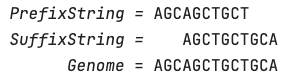

In [4]:
def StringFromKMers(kMersList):
    return ''.join([ kMersList[i][0] if i != len(kMersList)-1 else kMersList[i] for i in range(len(kMersList)) ])


def StringSpelledByGappedPatterns(GappedPatterns, k, d):
    '''
    Function to construct strings from paired reads, check, if they overlap at k+d position, and return concatenatenated string.
    '''
    PrefixPatterns = [ i.split('|')[0] for i in GappedPatterns ]
    SuffixPatterns = [ i.split('|')[1] for i in GappedPatterns ]

    PrefixString = StringFromKMers(PrefixPatterns)
    SuffixString = StringFromKMers(SuffixPatterns)

    for i in range(k+d, len(PrefixString)-1):

        if PrefixString[i] != SuffixString[i-k-d]:
            return "No similar strings!"
        
    return PrefixString[:k+d] + SuffixString


In [5]:
StringFromKMers(["AG", "GC", "CA", "AG", "GC", "CT", "TG", "GC", "CT"])

'AGCAGCTGCT'

In [ ]:
StringSpelledByGappedPatterns(
    k=3, d=1, GappedPatterns=[ i for i in input().split() ]
)

### String Reconstruction from Read-Pairs Problem: 
Reconstruct a string from its paired composition.

**Input**: A collection of paired k-mers PairedReads and an integer d.


**Output**: A string Text with (k,d)-mer composition equal to PairedReads (if such a string exists).

In [6]:
def DeBruijnPairedGraphFromKMers(kMersPairedList:list, printDict=False):
    PrefixDict = {}    
    
    for kMer in kMersPairedList:
        prefix = Prefix(kMer.split('|')[0]) + '|' + Prefix(kMer.split('|')[1])
        suffix = Suffix(kMer.split('|')[0]) + '|' + Suffix(kMer.split('|')[1])

        if prefix not in PrefixDict:
            PrefixDict[prefix] = list()
        PrefixDict[prefix].append(suffix)
    if printDict == True:
        for key, value in sorted(PrefixDict.items()):
            print(f"{key}:", *value)
    else:
        return PrefixDict

In [38]:
def StringReconstructionPairedReads(k:int, d:int, GappedPatterns:list):
    dbGraph = DeBruijnPairedGraphFromKMers(kMersPairedList=GappedPatterns)
    eulPath = EulerianPath(dbGraph)
    
    return StringSpelledByGappedPatterns(
        GappedPatterns=eulPath,
        k=k, d=d
    )

TAA|GCC ATG|GAT TGG|ATG GGG|TGT GGA|GTT AAT|CCA ATG|CAT TGC|ATG GCC|TGG CCA|GGG CAT|GGA

In [47]:
with open("/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/StringReconstructionReadPairs/inputs/input_5.txt") as inputfile:
    k, d = inputfile.readline().split()
    GappedPatterns = [ pair for pair in inputfile.readline().split() ]
    print(k, d, GappedPatterns)

x = StringReconstructionPairedReads(
    k=int(k), d=int(d), GappedPatterns=GappedPatterns
)
print("Result is:", x)

3 2 ['GGG|GGG', 'AGG|GGG', 'GGG|GGT', 'GGG|GGG', 'GGG|GGG']
AG|GG GG|GG
Result is: AGGGGGGGGGGT


In [48]:
with open("/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/StringReconstructionReadPairs/outputs/output_5.txt") as file:
    print("Answer is:", file.readline())

Answer is: AGGGGGGGGGGT


## Sequencing Real Problems

1. Imperfect Coverage

We can deal with it by using breaking reads. For example, we have 4 10-mers, which do not cover genome very well. We can break them into 5-mers, which will increase the coverage of genome.

Read breaking must deal with a practical trade-off. On the one hand, the smaller the value of k, the larger the chance that the k-mer coverage is perfect. On the other hand, smaller values of k result in a more tangled de Bruijn graph, making it difficult to infer the genome from this graph. 

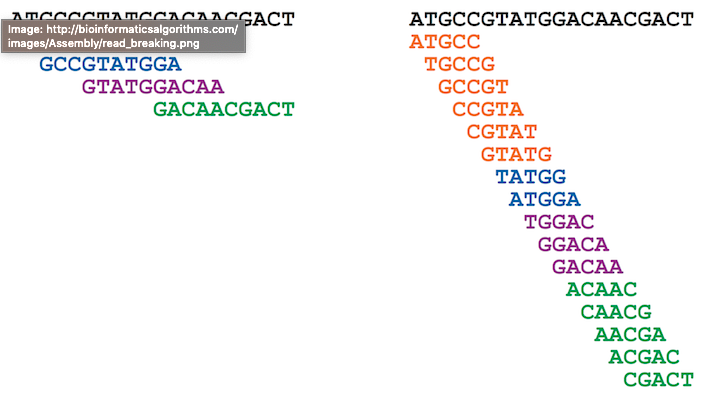

Even after read breaking, most assemblies still have gaps in k-mer coverage, causing the de Bruijn graph to have missing edges, and so the search for an Eulerian path fails. In this case, biologists often settle on assembling contigs

Fortunately, we can derive contigs from the de Bruijn graph. A path in a graph is called non-branching if in(v) = out(v) = 1 for each intermediate node v of this path, i.e., for each node except possibly the starting and ending node of a path. A **maximal non-branching path** is a non-branching path that cannot be extended into a longer non-branching path.

#### We start from creating list of Maximal Non Branching Path and Cycles, found in our Graph

In [96]:
def ConstructDictFromFile(dictFile, printDict=False):
    '''
    Func to construct dict from file
    '''
    with open(dictFile) as file:
        y = {
            line.split(': ')[0]:
            [ i for i in line.split(': ')[1].split() ]
            for line in file
    }
    if printDict == True:
        print(y)
    return y

In [175]:
def MaximalNonBranchingPath(Graph, genome=True):
    '''
    Function to search for maximal linear non-branching paths and separated cycles in Graph.
    '''
    Paths = list()
    Cycles = list()

    degreeGraph = CountDegrees(Graph)
    usedNodes = set() 

    for Node in degreeGraph: # идем по узлам графа
        if not degreeGraph[Node]["in"] == degreeGraph[Node]["out"]==1: # для узлов, которые могут быть началом пути (ин и аут !=1 и аут>0)
            if degreeGraph[Node]["out"] > 0:

                for Out in Graph[Node]:
                    NonBranchingPath = [Node, Out] # достраиваем путь по одному узлу

                    while degreeGraph[Out]["in"]==degreeGraph[Out]["out"]==1: # для каждого 1-1 узла, который идет дальше, мы достраиваем путь 
                        NonBranchingPath.append(Graph[Out][0])
                        Out = Graph[Out][0]
                    Paths.append(NonBranchingPath) # если встречаем узел не 1-1, тормозим и записываем получившийся узел в список
                    for i in NonBranchingPath: # все узлы записываем в использованные, чтобы избежать повтора циклов
                        usedNodes.add(i)

    for Node in degreeGraph:
        if degreeGraph[Node]["in"] == degreeGraph[Node]["out"]==1 and Node not in usedNodes: # для всех неиспользованных 1-1 узлов
            for Out in Graph[Node]: 
                    NonBranchingCycle = [Node, Out] # если такие узлы не попали в пути, значит они находятся в отдельном цикле

                    while degreeGraph[Out]["in"]==degreeGraph[Out]["out"]==1 and NonBranchingCycle[0] == Out: 
                        NonBranchingCycle.append(Graph[Out][0]) # также итерируем по 1-1 узлам, пока они 1-1 или пока не встретим начало цикла
                        Out = Graph[Out][0]
    
                    print("Found Cycle")
                    NonBranchingCycle.append(Graph[Out][0]) # выходим из цикла, записываем последний элемент (равен началу цикла)
                    Paths.append(NonBranchingCycle)
                    for i in NonBranchingCycle: # все узлы записываем в использованные, чтобы избежать повтора циклов
                        usedNodes.add(i)
                    break

    if genome==True: # для нуклеотидных последовательностей выводим склейки узлов, т.е. сами Контиги
        return [PathToGenome(path) for path in Paths]
    else:
        return [' -> '.join(path) for path in Paths]

In [176]:
MaximalNonBranchingPath(
    ConstructDictFromFile('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/MaximalNonBranchingPaths/inputs/input_1.txt'),
    genome=False
)

Found Cycle


['1 -> 2 -> 3', '3 -> 4', '3 -> 5', '6 -> 7 -> 6']

#### After we have succedded, we can use function above to work with Genome Graphs and to glue nodes toghether to Contigs, which will be our answer

In [209]:
def CreateContigsList(kMersList, printOut=False):
    pathList = MaximalNonBranchingPath(
        Graph=DeBruijnGraphFromKMers(kMersList=kMersList, printDict=False),
        genome=True
    ) # получаем список максимальных неветвящихся путей и циклов в Графе = набор контигов 
    if printOut:
        for Path in sorted(pathList):
            print(Path, end=' ')
    else:  
        return pathList


def CreateContigsListFromPairedReads(kMersPairedList, printOut=False):
    pathList = MaximalNonBranchingPath(
        Graph=DeBruijnPairedGraphFromKMers(kMersPairedList=kMersPairedList, printDict=False),
        genome=True
    ) # получаем список максимальных неветвящихся путей и циклов в Графе = набор контигов 
    if printOut:
        for Path in sorted(pathList):
            print(Path, end=' ')
    else:  
        return pathList


with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/ContigGeneration/inputs/input_5.txt') as file:
    kMers = [i for i in file.readline().strip().split()]

CreateContigsList(kMersList=kMers, printOut=True)

CTGA CTGA GACTG TGAG 

In [210]:
with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/ContigGeneration/outputs/output_5.txt') as file:
    answer = sorted([i for i in file.readline().split()])
    print("Answer from file is:")
    print(*answer)

Answer from file is:
CTGA CTGA GACTG TGAG


#### As a result we cat provide list of Contigs, which is common for prokaryotes genomes assembly

## Assembling Errore-Prone Reads
Error-prone reads represent yet another barrier to real sequencing projects. Adding the single erroneous read CGTACGGACA (with a single error that misreads T as C) to the set of "broken" 5-mer reads from earlier in the lesson results in erroneous 5-mers CGTAC, GTACG, TACGG, ACGGA, and CGGAC after read breaking. 

These 5-mers result in an erroneous path from node CGTA to node GGAC in the de Bruijn graph below, meaning that if the correct read CGTATGGACA is generated as well, then we will have two paths connecting CGTA to GGAC in the de Bruijn graph. This structure is called a bubble, which we define as two short disjoint paths (e.g., shorter than some threshold length) connecting the same pair of nodes in the de Bruijn graph.

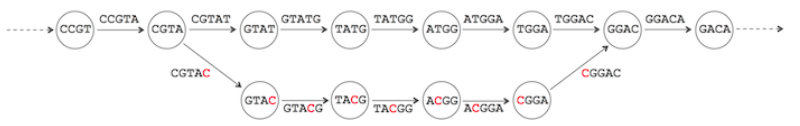

For a single-error k-mer, the bubble is  k edges long, and k-1 nodes belong exclusively in the bubble.

## Final Challenge: 
***Carsonella ruddii*** is a bacterium that lives symbiotically inside some insects. Its sheltered life has allowed it to reduce its genome to only about 160,000 base pairs. With only about 200 genes, it lacks some genes necessary for survival, but these genes are supplied by its insect host. In fact, Carsonella has such a small genome that biologists have conjectured that it is losing its “bacterial" identity and turning into an organelle, which is part of the host’s genome.

Given a collection of **simulated error-free read-pairs** (with exact distance d = 1000 between reads of length k = 120 within a read-pair), **use the paired de Bruijn graph to reconstruct the Carsonella ruddii genome**. 

Compare this assembly to the assembly obtained from the classic de Bruijn graph (i.e., when all we know is the reads themselves and do not know the distance between paired reads) in order to better appreciate the benefits of read-pairs. 

For each k, what is the minimum value of d needed to enable reconstruction of the entire Carsonella ruddii genome from its (k,d)-mer composition?

In [211]:
with open('/Users/olegsuchalko/BioinformaticsAlgorithms/II.GenomeSequencing/Week_1/Carsonella_ruddii_genome.txt') as reads:
    pairedReads = [ readPair.strip() for readPair in reads.readlines() ]

In [217]:
x = DeBruijnPairedGraphFromKMers(
    kMersPairedList=pairedReads
)

print("Nodes:", len(x.keys()))


Nodes: 6609
